In [5]:
import pymongo
from pprint import pprint
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Set, Tuple
import functools as ft
import numpy as np
import random
#from spacy.tokens import DocBin
from spacy import displacy
from tqdm import tqdm
from constants import utc_to_dt, COLL, PSAW, PRAW
import spacy
#from explore_build import text_to_spacy
from collections import Counter
from praw import Reddit
from psaw import PushshiftAPI
from IPython.core.display import display, HTML
nlp = spacy.load("en_core_web_sm")

# User Histories

### 1. Load data from Mongo/Reddit

In [289]:
# read in data and filter missing text
# users_df = pd.read_csv("data/top10_users.csv").dropna()
users_df = top_histories

In [292]:
# convert text to spacy docs
text_docs = [t for t in users_df["text"].tolist() if type(t) == str]
spacy_docs = []
for t in tqdm(text_docs):
    spacy_docs.append(nlp(t))

100%|██████████| 60402/60402 [11:46<00:00, 85.55it/s] 


In [310]:
# convert text to spacy docs with subreddit name
users_df["text_sub"] = list(map(lambda x, y: x + " " + str(y),
                                users_df["text"].tolist(),
                                users_df["subreddit"].tolist()))

In [312]:
# convert text to spacy docs
text_docs = [t for t in users_df["text_sub"].tolist() if type(t) == str]
spacy_subr = []
for t in tqdm(text_docs):
    spacy_subr.append(nlp(t))

100%|██████████| 60402/60402 [12:30<00:00, 80.48it/s] 


In [313]:
# add spacy docs to users dataframe
# temp_docs = text_docs.copy()
# spacy_col = [temp_docs.pop() if type(t) == str else None for t in users_df["text"].tolist()]
users_df["spacy"] = spacy_docs
users_df["spacy_sub"] = spacy_subr

### Optional write spacy to disk

In [295]:
# write space docs to disk
doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"],
                 store_user_data=True)
for doc in tqdm(spacy_docs):
    doc_bin.add(doc)
    
# write bytes data to file
spacy_fp = "data/top6_history.spacy"
bytes_data = doc_bin.to_bytes()
out_f = open(spacy_fp, "wb")
out_f.write(bytes_data)

NameError: name 'DocBin' is not defined

In [8]:
# sample read in of written docs
docbin = DocBin().from_bytes(open(spacy_fp, "rb").read())
disk_docs = docbin.get_docs(nlp.vocab)
disk_docsl = list(disk_docs)

### 2. Extract entities

In [282]:
users_df.tail(10)

,username,text,subreddit,is_sub,id,spacy,ents
1502,realcat67,I like this! Did you write it?,opiateswriters,False,fdqyi54,"(I, like, this, !, Did, you, write, it, ?)",None
1503,realcat67,Normal 10 panel.\n\nMy guess:\n\nop = opiates\...,opiates,False,fdqskd0,"(Normal, 10, panel, ., \n\n, My, guess, :, \n\...","[(10), (BUP), (300), (BRAL)]"
1504,realcat67,I know there is info on the sub about extracti...,opiates,False,fdqpyo4,"(I, know, there, is, info, on, the, sub, about...",None
1505,realcat67,An awesome question. I feel the same way.,opiates,False,fdp7wr8,"(An, awesome, question, ., I, feel, the, same,...",None
1506,realcat67,Better surrounded\n\nThan wasting away alone\n...,opiateswriters,False,fdp7b8h,"(Better, surrounded, \n\n, Than, wasting, away...",None
1507,realcat67,1. I think you are trying to just force your t...,wrestling,False,fdohozc,"(1, ., I, think, you, are, trying, to, just, f...","[(1), (2)]"
1508,realcat67,That's great that you quit drinking! Good luck...,opiates,False,fdn6afi,"(That, 's, great, that, you, quit, drinking, !...",None
1509,realcat67,Its very awesome\n\ncreation is the best thing...,opiateswriters,False,fdlzsga,"(Its, very, awesome, \n\n, creation, is, the, ...",None
1510,realcat67,When a Shade happens across and immensely pow...,BetaReaders,False,fdlsgzi,"( , When, a, Shade, happens, across, and, imme...","[(Shade), (Shade)]"
1511,realcat67,lol 20 million frenchmen cannot be wrong!,asktrp,False,fm9u1r0,"(lol, 20, million, frenchmen, can, not, be, wr...","[(20, million)]"


In [314]:
users_df["ents"] = map(-> list(_.ents) if len(_.ents) > 0 else None, users_df["spacy"].tolist()) |> list
users_df["ents_sub"] = map(-> list(_.ents) if len(_.ents) > 0 else None, users_df["spacy_sub"].tolist()) |> list
ents_df = users_df.dropna()

In [355]:
[i for i, ents in enumerate(ents_df["ents"].tolist()) if "atlanta" in [str(e).lower() for e in ents]]

[2088, 2089, 2104, 2113, 2118, 2152, 2153, 2689, 2704, 2764, 3446, 3743]

In [357]:
atlanta_df = ents_df.iloc[[2088, 2089, 2104, 2113, 2118, 2152, 2153, 2689, 2704, 2764, 3446, 3743],:]

In [363]:
atlanta_df.head()

,username,text,subreddit,is_sub,id,spacy,ents,text_sub,spacy_sub,ents_sub
38,realcat67,"Im in Atlanta, GA, and I am down to about 3 M...",techsupport,True,fljyyk,"( , I, m, in, Atlanta, ,, GA, ,, and, I, am, d...","[(Atlanta), (GA), (about, 3), (Mbps), (years)]","Im in Atlanta, GA, and I am down to about 3 M...","( , I, m, in, Atlanta, ,, GA, ,, and, I, am, d...","[(Atlanta), (GA), (about, 3), (Mbps), (years)]"
74,realcat67,A junkie is traveling home to Atlanta after a...,opiateswriters,True,fcxlrl,"( , A, junkie, is, traveling, home, to, Atlant...","[(Atlanta), (one), (Avenge, Fifi), (at, least,...",A junkie is traveling home to Atlanta after a...,"( , A, junkie, is, traveling, home, to, Atlant...","[(Atlanta), (one), (Avenge, Fifi), (at, least,..."
201,realcat67,"I don’t see it discussed much, but I have alw...",opiateswriters,True,em1j8n,"( , I, do, n’t, see, it, discussed, much, ,, b...","[(6, am), (Atlanta), (Bluff), (Run, Every, Dru...","I don’t see it discussed much, but I have alw...","( , I, do, n’t, see, it, discussed, much, ,, b...","[(6, am), (Atlanta), (Bluff), (Run, Every, Dru..."
326,realcat67,"My main guy was called Big Slim, because he ...",opiateswriters,True,dqozup,"(My, , main, guy, was, called, Big, , Slim, ...","[(6), (7), (Atlanta), (Big, Slim), (15, minute...","My main guy was called Big Slim, because he ...","(My, , main, guy, was, called, Big, , Slim, ...","[(6), (7), (Atlanta), (Big, Slim), (15, minute..."
378,realcat67,I just got a job as an assistant coach at a lo...,wrestling,True,dgfbcg,"(I, just, got, a, job, as, an, assistant, coac...","[(Atlanta), (first), (One), (13), (the, 8, -, ...",I just got a job as an assistant coach at a lo...,"(I, just, got, a, job, as, an, assistant, coac...","[(Atlanta), (first), (One), (13), (the, 8, -, ..."


In [359]:
atlanta_df["id"]

38       fljyyk
74       fcxlrl
201      em1j8n
326      dqozup
378      dgfbcg
497      cowf5r
498      cow1up
2005    f374e21
2047    f1rw62n
2263    f0qezbg
4042    egfmaqa
4682    efhqftl
Name: id, dtype: object

In [362]:
print(atlanta_df["text"].tolist())

[' Im in Atlanta, GA, and I am down to about 3 Mbps. I guess people working at home? It has been years since I have seen speeds this low. Are other people experiencing this?', ' A junkie is traveling home to Atlanta after an exhausting holiday visit with the in-laws.\n\nThe   train was quite crowded, and the junkie walked the entire length, looking for a seat. There seemed to be one next to a well-dressed   middle-aged woman, but when he got there he saw it was taken by the   woman\'s poodle. The tired junkie asked, "Ma\'am, may I have that seat?"\n\nThe woman sniffed and said, "Absolutely not.. My little Fifi is sitting there."\n\nThe   junkie walked the entire train again, but the only seat available was  under that dog. "Please, ma\'am. May I sit down? I\'m very tired."\n\nShe   snorted, "Not only are you rude, you are also arrogant!" This time the   junkie didn\'t say a word; he just picked up the little dog, tossed it  out the train window and sat down.\n\nThe woman shrieked, "Som

In [326]:
plain_ents = ft.reduce(lambda x, y: x + y, ents_df["ents"].tolist(), [])
sub_ents = ft.reduce(lambda x, y: x + y, ents_df["ents_sub"].tolist(), [])

In [345]:
def get_ents(u: str):
    grouped_ents = ents_df.loc[ents_df["username"] == u, :]["ents"].tolist()
    return ft.reduce((x, y) -> x + y, grouped_ents, [])

In [346]:
def ents_by_type(ents, etype):
    filt_ents = ents |> filter$(-> _.label_ == etype) |> list
    gpes_text = filt_ents |> map$(-> _.text.lower().strip(".")) |> list
    return gpes_text

In [347]:
u1_ents = get_ents("realcat67")
u1_gpe = ents_by_type(u1_ents, "GPE")

In [340]:
all_ents = ft.reduce((x, y) -> x + y, ents_df["ents"].tolist())
sub_ents = ents_by_type(all_ents, "GPE")

In [348]:
gpe_counts =  pd.DataFrame(sorted(dict(Counter(u1_gpe)).items(), key=-> _[1], reverse=True))

In [349]:
gpe_counts.columns = ["Quantity", "Frequency Count"]
gpe_counts.head(10)

,Quantity,Frequency Count
0,us,54
1,georgia,28
2,america,17
3,mexico,16
4,uk,14
5,atlanta,12
6,thalia,11
7,usa,10
8,germany,6
9,soma,5


### 3. User Plots

In [290]:
users_df["username"].unique()

array(['R1chPorter', 'cozywarmedblanket', 'realcat67', 'spinderella69',
       'NotPoliticalyCorrect', 'zombilives'], dtype=object)

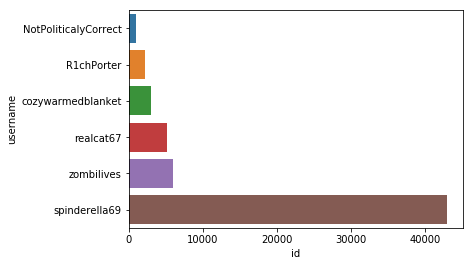

In [291]:
user_counts = users_df.groupby("username").count().sort_values("id").reset_index()
sns.barplot(y="username", x="id", data=user_counts, orient="h")
plt.show()

In [303]:
# visualize entities
docs = ents_df["spacy"].tolist()[900:902]
vis_docs = [d for d in docs if len(d.ents) > 0]
for i, d in enumerate(vis_docs):
    print("Doc:", i)
    display(HTML(displacy.render(d, style='ent', page=True)))

Doc: 0


Doc: 1


In [46]:
users_df["gpes"] = users_df["spacy"].apply(lambda x: [e for e in x.ents if e.label_ == "GPE"])

In [78]:
gpes_by_user

,username,gpes
0,FashionablyFake,"[(Kilos), (soooo), (Dallas), (Whatevz), (bk), ..."
1,KickerS12X,"[(kiddo), (Vermont), (xanax), (north, troy), (..."
2,OlDirtyBurton,"[(APVP), (US), (Adderall), (US), (US), (Tina),..."
3,chasing-d0pamine,"[(Wharton), (Adderall), (america), (Adderall),..."
4,heroinking,"[(turkey), (turkey), (APVP), (APVP), (turkey),..."
5,spinderella69,"[(NY), (Molly), (kinda), (Kratom), (Kratom), (..."
6,street_philatelist,"[(Fentanyl, Warnings, State), (SN), (Florida),..."
7,traceyh415,"[(R.C.), (Chicago), (Phoenix), (AZ), (Seattle)..."


In [73]:
gpes_by_user = users_df.groupby("username").agg({"gpes": lambda x: ft.reduce(lambda acc, y: acc + y, x)}).reset_index()

In [83]:
Counter([e.text for e in gpes_by_user["gpes"][4]]).most_common()

[('APVP', 127),
 ('Adderall', 107),
 ('US', 54),
 ('Seroquel', 25),
 ('Xanax', 18),
 ('USA', 16),
 ('Discord', 11),
 ('Wisconsin', 9),
 ('APHP', 9),
 ('China', 8),
 ('America', 8),
 ('UK', 8),
 ('LE', 7),
 ('Canada', 7),
 ('California', 7),
 ('turkey', 6),
 ('Tylenol', 6),
 ('Florida', 6),
 ('Missouri', 6),
 ('Mexico', 5),
 ('Walmart', 5),
 ('Vendor', 5),
 ('Minneapolis', 4),
 ('MDPV', 4),
 ('M1', 4),
 ('Tina', 4),
 ('Ketamine', 4),
 ('Molly', 4),
 ('Oxycodone', 4),
 ('Miami', 3),
 ('Opana', 3),
 ('meth', 3),
 ('Valium', 3),
 ('Ambien', 3),
 ('Temazepam', 3),
 ('Pentylone', 3),
 ('Hydrocodone', 3),
 ('Codeine', 3),
 ('JJ', 3),
 ('PWD', 3),
 ('Minnesota', 3),
 ('Eminem', 3),
 ('pedophilia', 3),
 ('china', 2),
 ('LSD', 2),
 ('Oxy', 2),
 ('Russia', 2),
 ('Bitcoin', 2),
 ('India', 2),
 ('Ativan', 2),
 ('Klonopin', 2),
 ('Utah', 2),
 ('blotter', 2),
 ('Vicodin', 2),
 ('xanax', 2),
 ('tina', 2),
 ('incognito', 2),
 ('Houston', 2),
 ('Elvis', 2),
 ('Pornhub', 2),
 ('adderall', 2),
 ('Nevada',

In [72]:
gpes_by_user["gpes"][3]

Counter({(Wharton, 1): 1,
         (Adderall, 1): 1,
         (america, 1): 1,
         (Adderall, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (Seroquel, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (va va va, 1): 1,
         (kinda, 1): 1,
         (Adderall, 1): 1,
         (Suburbia, 1): 1,
         (Xanax, 1): 1,
         (US, 1): 1,
         (Ulta, 1): 1,
         (India, 1): 1,
         (New York, 1): 1,
         (New York, 1): 1,
         (Adderall, 1): 1,
         (Aexandria, 1): 1,
         (Mexico, 1): 1,
         (US, 1): 1,
         (RX, 1): 1,
         (Vitamultin, 1): 1,
         (turkey, 1): 1,
         (turkey, 1): 1,
         (Ulta, 1): 1,
         (Kanye, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (blockchain, 1): 1,
         (Adderall, 1): 1,
         (Canada, 1): 1,
         (APVP, 1): 1,
         (Scotland, 1): 1,
         (Scotland, 1): 1,
         (Tumblr, 1): 1,
         

## Word Usage

In [78]:
def word_per_year(df: pd.DataFrame, words: List[str], user_counts: List[int]) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda year: df.loc[df.year == year, "lower_text"].apply(check_in).sum()
    word_counts: List[int] = [countw(year) for year in years]
    wc_norm: List[float] = [w / u for w, u in zip(word_counts, user_counts)]
    return pd.DataFrame({"years": years, "word_counts": word_counts, "wc_norm": wc_norm})

def append_wc(df: pd.DataFrame, words: List[List[str]], user_counts: List[int]) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, user_counts)), words, pd.DataFrame())
    nyear = df.year.unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df

### 1. Location Mentions

In [83]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
loc_words = [["boston", "beantown", "bos"], ["lawrence"], ["lowell"], ["manchester"], ["worcester"]]
loc_df = append_wc(full_df, loc_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

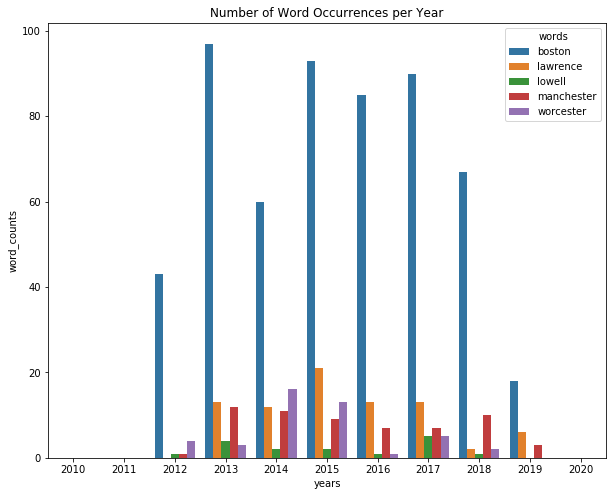

In [84]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=wc_df)
ax.set_title(f"Number of Word Occurrences per Year")

### 2. Drug Mentions

In [85]:
drug_words = [["fentanyl", "fent", "fenty"], ["heroin"]]
drug_df = append_wc(full_df, drug_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

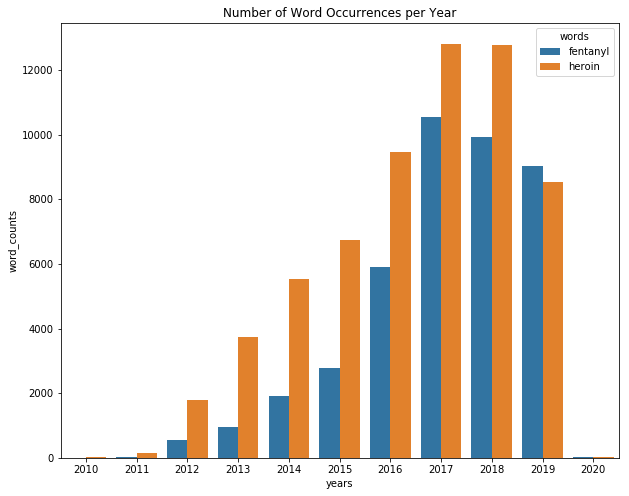

In [86]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=drug_df)
ax.set_title(f"Number of Word Occurrences per Year")

# Summative Visualizations

## Date Distributions

In [5]:
full_df["date"] = full_df.time.apply(lambda ts: date(ts.year, ts.month, ts.day))
date_groups = full_df.groupby("date").count().reset_index()

In [ ]:
df_19 = date_groups.loc[date_groups["date"] >= date(2019, 1, 1), :]
sns.barplot(x="date", y="hash", data=df_19)

## Number of Posts Over Time

### 1. Count of Submissions Over Time

Text(0.5, 1.0, 'Number of r/opiates Submissions Over Time')

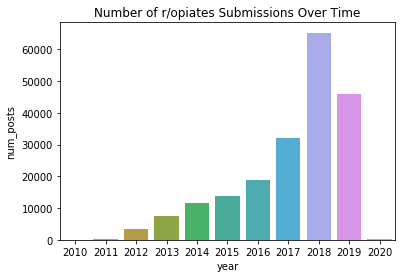

In [39]:
count_df = sub_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Submissions Over Time")

### 2. Count of Submissions + Comments Over Time

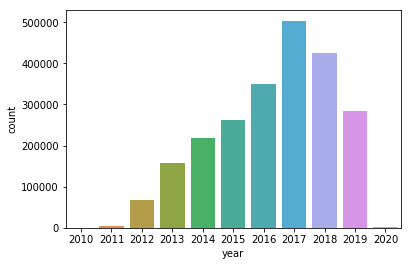

In [21]:
# group by year
query_str = { 
    "$group": { 
        "_id": { 
            "year": {"$year": "$time"}}, 
        "count": {
            "$sum": 1
        },
        "subs": {"$sum": 1}
    }
}
query = COLL.aggregate([query_str])

# extract data
query_li = list(query)
years = [str(it["_id"]["year"]) for it in query_li]
counts = [it["count"] for it in query_li]

# create dataframe
df = pd.DataFrame({"year": years, "count": counts})

# plot
sns.barplot(x="year", y="count", data=df)

### 3. Count of Submissions + Real Comments

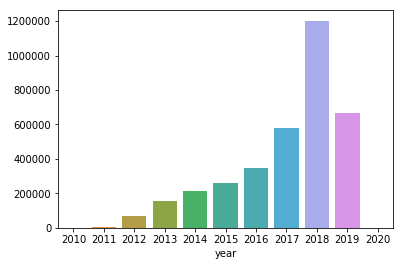

In [55]:
sub_df.query("year == '2017'").shape[0]
comms = sub_df.groupby("year")["num_comments"].sum().tolist()
subs = sub_df.groupby("year").count()
combined = [a + b for a, b in zip(comms, subs["hash"].tolist())]
sns.barplot(x=subs.index, y=combined)

### 4. Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

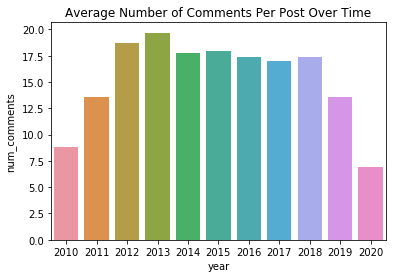

In [40]:
comm_df = sub_df.loc[:,["year", "num_comments"]].dropna().groupby("year")\
                                                .mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

In [57]:
comm_counts = full_df.groupby("parent_id").count().reset_index()
comm_counts["new_par_id"] = comm_counts["parent_id"].apply(lambda x: x.replace("t1_", ""))

## Active Number of Users on R/Opiates Over Time

In [18]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "username"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

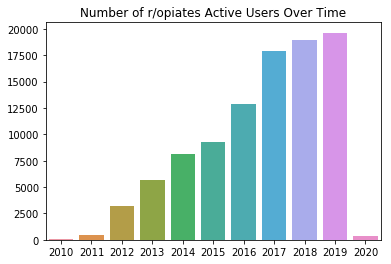

In [19]:
years, user_counts = users_per_year(full_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Frequency Table

In [245]:
freq_df = pd.DataFrame(list(COLL.find({})))
freq_df["year"] = freq_df.time.apply(lambda x: str(x.year))

In [246]:
freq_df["Threads"] = freq_df["is_sub"].apply(lambda x: 1 if x else 0)
freq_df["Comments"] = freq_df["is_sub"].apply(lambda x: 1 if (not x) else 0)
freq_df["Totals"] = [1] * freq_df.shape[0]
count_df = freq_df.groupby("year").sum().loc[:,["Threads", "Comments", "Totals"]]

In [247]:
count_df

,Threads,Comments,Totals
year,,,
2019,175.0,2162.0,2337.0
